In [1]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import tensorflow as tf
from PIL import Image

*   # **Data Exploration/Cleaning**

In [5]:
# Set paths to image and mask directories
image_dir = '/kaggle/input/satellite/data/images'
mask_dir = '/kaggle/input/satellite/data/labels'

# Load the first image and corresponding mask
image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
mask_path = os.path.join(mask_dir, os.listdir(mask_dir)[0])

# Load the multispectral image (.tif)
with rasterio.open(image_path) as src:
    image = src.read()  # shape: (12, 128, 128)
    image = np.moveaxis(image, 0, -1)  # convert to shape: (128, 128, 12)

# Load the binary mask (.png)
mask = np.array(Image.open(mask_path))

# Display shape and unique values
print("Image shape:", image.shape)
print("Image dtype:", image.dtype)
print("Mask shape:", mask.shape)
print("Unique values in mask:", np.unique(mask))

Image shape: (128, 128, 12)
Image dtype: int16
Mask shape: (128, 128)
Unique values in mask: [0 1]


In [6]:
##--Normalize image--##

def normalize_image(img):
    img = img.astype(np.float32)
    img_min = np.min(img)
    img_max = np.max(img)
    normalized = (img - img_min) / (img_max - img_min + 1e-6)
    return normalized

normalized_image = normalize_image(image)

# Confirm results
print("Before normalization:", image.min(), image.max())
print("After normalization:", normalized_image.min(), normalized_image.max())
print("New dtype:", normalized_image.dtype)


Before normalization: -375 6073
After normalization: 0.0 1.0
New dtype: float32


In [7]:
# Convert mask to float32
mask = mask.astype(np.float32)

# Optional: expand dims if needed (e.g., (128, 128) → (128, 128, 1))
mask = np.expand_dims(mask, axis=-1)

print("Mask shape after expand:", mask.shape)
print("Mask dtype:", mask.dtype)
print("Mask unique values:", np.unique(mask))



Mask shape after expand: (128, 128, 1)
Mask dtype: float32
Mask unique values: [0. 1.]


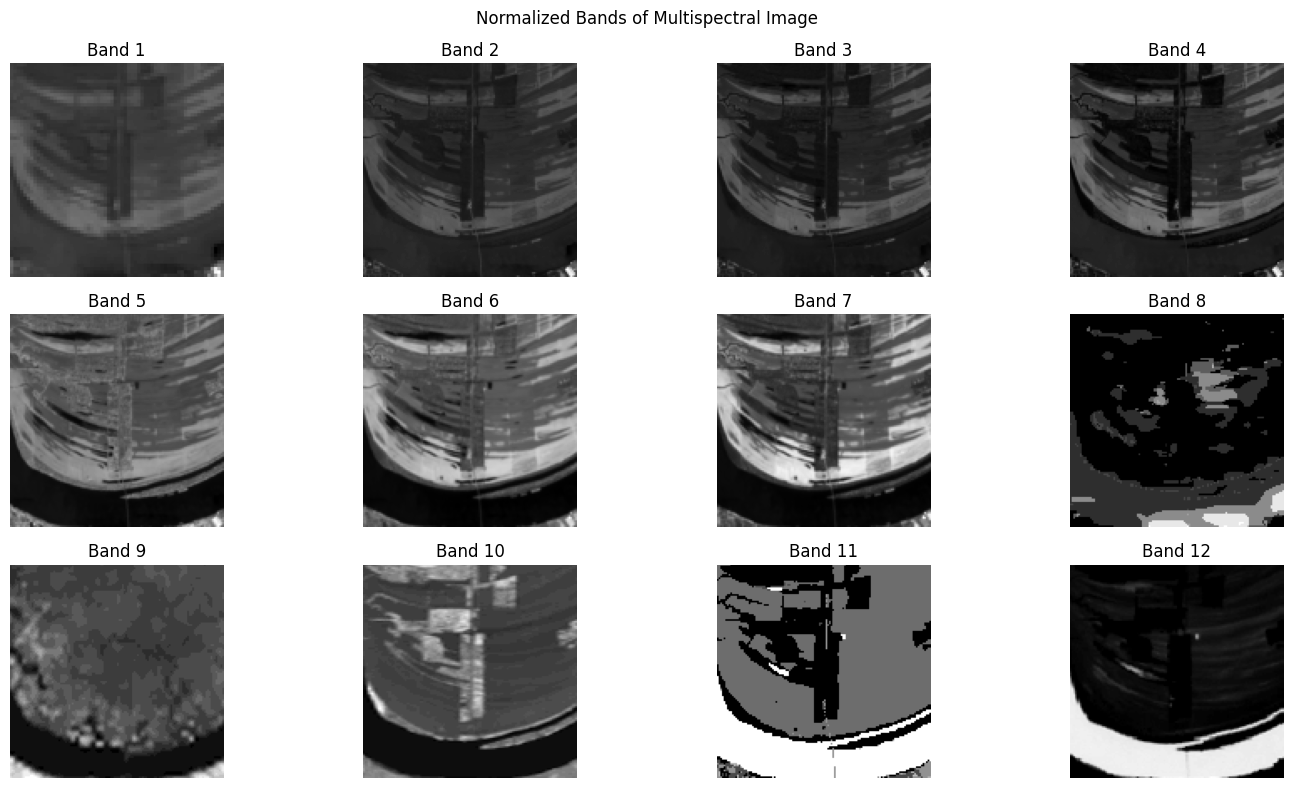

In [8]:
#Sample of normalized band
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min() + 1e-6)

# Plot the 12 bands in a grid
plt.figure(figsize=(15, 8))
for i in range(12):
    band = image[:, :, i
    ]
    norm_band = normalize_band(band)
    plt.subplot(3, 4, i+1)
    plt.imshow(norm_band, cmap='gray')
    plt.title(f'Band {i+1}')
    plt.axis('off')

plt.suptitle('Normalized Bands of Multispectral Image')
plt.tight_layout()
plt.show()

* # **Preprocessing**

In [9]:
##--Load data and normalize it--##

# Load and sort filenames without extensions
image_names = set([f.replace('.tif', '') for f in os.listdir(image_dir) if f.endswith('.tif')])
mask_names = set([f.replace('.png', '') for f in os.listdir(mask_dir) if f.endswith('.png')])

# Intersect to get common files
common_names = sorted(list(image_names & mask_names))

# Now create full paths again
image_files = [os.path.join(image_dir, name + '.tif') for name in common_names]
mask_files = [os.path.join(mask_dir, name + '.png') for name in common_names]

print("Matched image-mask pairs:", len(image_files))

Matched image-mask pairs: 306


In [10]:
def load_and_preprocess(image_path, mask_path):
    # Decode bytes to string (TensorFlow inputs are tf.string)
    image_path = image_path.numpy().decode('utf-8')
    mask_path = mask_path.numpy().decode('utf-8')

    # Load image (.tif) using rasterio
    with rasterio.open(image_path) as src:
        image = src.read()  # shape: (12, 128, 128)
        image = np.moveaxis(image, 0, -1)  # (128, 128, 12)
        image = image.astype(np.float32)
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

    # Load mask (.png) using PIL
    mask = np.array(Image.open(mask_path)).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)  # (128, 128, 1)

    return image, mask


In [17]:
def augment_image_and_mask(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotation 90°
    if tf.random.uniform(()) > 0.5:
        k = tf.random.uniform((), minval=1, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        mask = tf.image.rot90(mask, k=k)

    # Optional: Brightness on first 3 bands (assumed as RGB)
    if tf.random.uniform(()) > 0.5:
        rgb = tf.image.random_brightness(image[..., :3], max_delta=0.1)
        image = tf.concat([rgb, image[..., 3:]], axis=-1)

    return image, mask


In [18]:
def tf_wrapper(image_path, mask_path):
    image, mask = tf.py_function(func=load_and_preprocess,
                                 inp=[image_path, mask_path],
                                 Tout=[tf.float32, tf.float32])
    
    image.set_shape([128, 128, 12])
    mask.set_shape([128, 128, 1])

    # Apply augmentation after loading and preprocessing
    image, mask = augment_image_and_mask(image, mask)

    return image, mask


In [22]:
# Create TensorFlow dataset
path_ds = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

# Map preprocessing function
dataset = path_ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, prefetch
train_dataset = dataset.shuffle(100).batch(8).prefetch(tf.data.AUTOTUNE)


In [23]:
for images, masks in train_dataset.take(1):
    print("Images batch shape:", images.shape)
    print("Masks batch shape:", masks.shape)
    print("Image dtype:", images.dtype)
    print("Mask dtype:", masks.dtype)


Images batch shape: (8, 128, 128, 12)
Masks batch shape: (8, 128, 128, 1)
Image dtype: <dtype: 'float32'>
Mask dtype: <dtype: 'float32'>


In [24]:
import matplotlib.pyplot as plt

# Define which bands to visualize (e.g., bands 4, 3, 2)
BAND_RED = 3
BAND_GREEN = 2
BAND_BLUE = 1

def show_sample(image, mask, idx=0):
    img = image[idx].numpy()
    msk = mask[idx].numpy().squeeze()

    # Pick selected bands and stack into RGB
    rgb = np.stack([
        img[:, :, BAND_RED],
        img[:, :, BAND_GREEN],
        img[:, :, BAND_BLUE]
    ], axis=-1)

    # Normalize for display
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

    # Plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title("RGB Composite (Bands 4-3-2)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(msk, cmap='gray')
    plt.title("Water Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


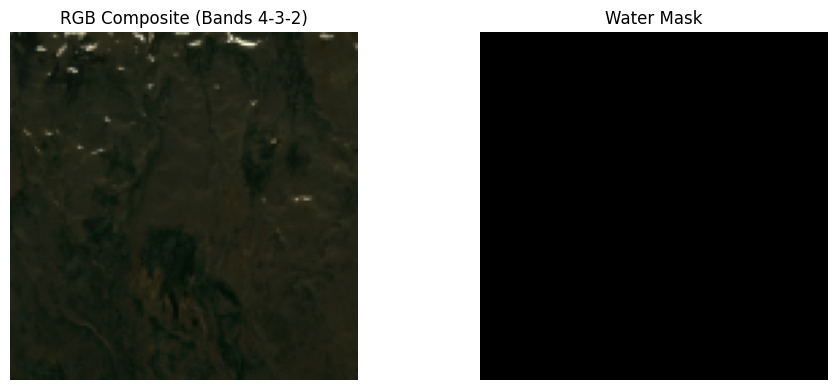

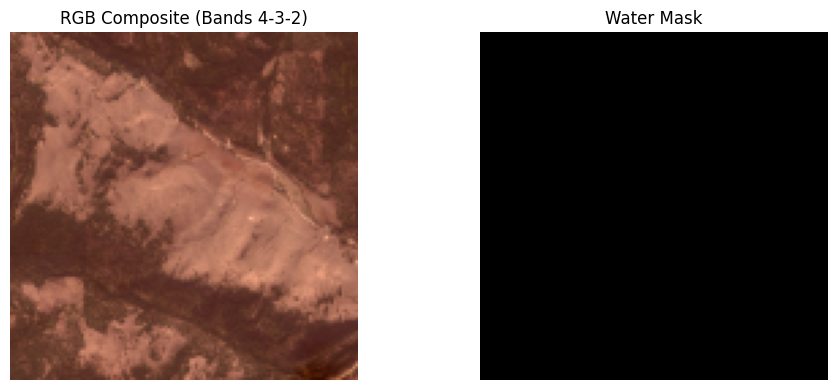

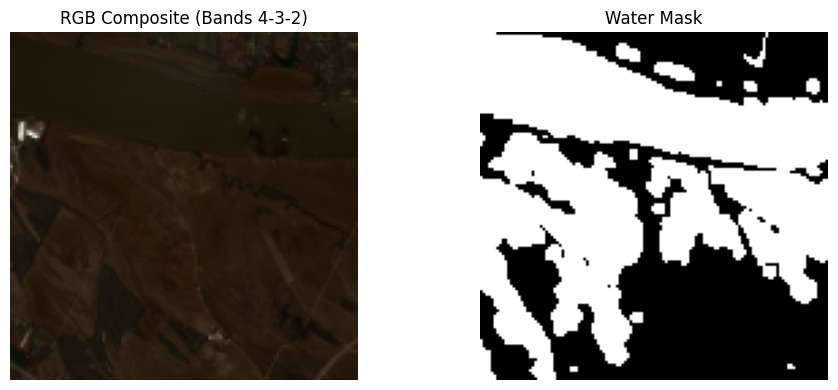

In [25]:
for i in range(3):
    show_sample(images, masks, idx=i)

* # **data split** 

In [26]:
from sklearn.model_selection import train_test_split

# Step 1: Split paths
train_images, val_images, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# Step 2: Build train & val datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))

# Step 3: Map preprocessing
train_dataset = train_ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

# Step 4: Shuffle, Batch, Prefetch
train_dataset = train_dataset.shuffle(100).batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(8).prefetch(tf.data.AUTOTUNE)


* # **Modeling** 

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
def unet_model(input_shape=(128, 128, 12)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    b = layers.BatchNormalization()(b)
    b = layers.Dropout(0.3)(b)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)
    b = layers.BatchNormalization()(b)

    # Decoder
    u3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u3 = layers.concatenate([u3, c3])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u2 = layers.concatenate([u2, c2])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u1 = layers.concatenate([u1, c1])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [28]:
model = unet_model(input_shape=(128, 128, 12))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,488 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[

 Total params: 1,933,825 (7.38 MB)

 Trainable params: 1,931,009 (7.37 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint('best_unet_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

callbacks = [early_stop, checkpoint, reduce_lr]


In [32]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks
)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8493 - loss: 0.4275
Epoch 1: val_loss improved from inf to 4.40487, saving model to best_unet_model.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8496 - loss: 0.4267 - val_accuracy: 0.2306 - val_loss: 4.4049 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8506 - loss: 0.4072
Epoch 2: val_loss improved from 4.40487 to 0.63130, saving model to best_unet_model.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8513 - loss: 0.4060 - val_accuracy: 0.7021 - val_loss: 0.6313 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8675 - loss: 0.3669
Epoch 3: val_loss improved from 0.63130 to 0.53500, saving model to best_unet_model.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8676 - loss: 0.3666 - val_accuracy: 0.7704 - val_loss: 0.5350 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8868 - los

In [33]:
model.save("water_segmentation.h5")


In [34]:
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.9154 - loss: 0.2251
Validation Loss: 0.2122
Validation Accuracy: 0.9190


In [35]:
# Get one batch of validation data
for images, true_masks in val_dataset.take(1):
    pred_masks = model.predict(images)
    break

# Apply threshold to convert probabilities to binary (0 or 1)
pred_binary = (pred_masks > 0.5).astype(np.uint8)
true_binary = true_masks.numpy().astype(np.uint8)

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Flatten arrays (needed for sklearn metrics)
y_true = true_binary.flatten()
y_pred = pred_binary.flatten()

# Compute metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
iou = jaccard_score(y_true, y_pred)

# Display results
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 128, 128, 12))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Precision: 0.9009
Recall:    0.6011
F1-score:  0.7211
IoU:       0.5638


In [39]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    # Get the available metrics from the history object
    available_metrics = list(history.history.keys())

    # Filter the metrics list to only include the available ones
    metrics = [m for m in ['loss', 'accuracy', 'val_loss', 'val_accuracy'] if m in available_metrics]

    plt.figure(figsize=(16, 10))
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label=metric)
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} Over Epochs")
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


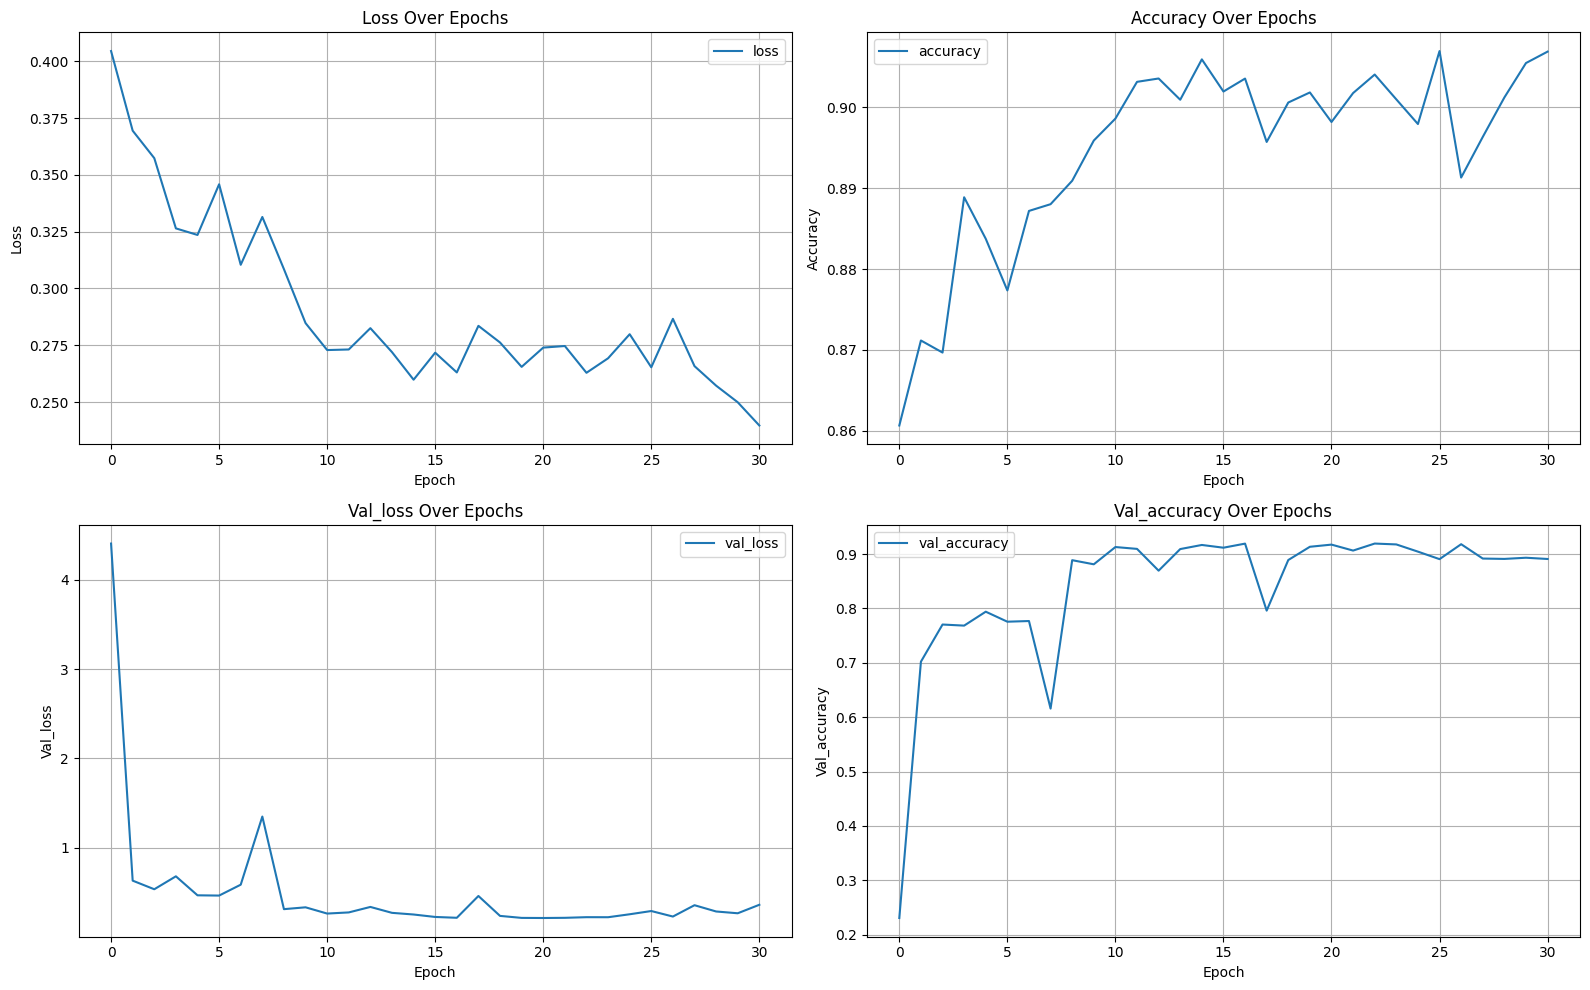

In [40]:
plot_training_curves(history)
